# Osnovna analiza podataka

In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from shapely.geometry import Point,Polygon
import geopandas as gpd
import descartes
import contextily as cx
import warnings
warnings.filterwarnings('ignore')

U ovoj svesci ce biti prikazani podaci vezani za nekretnine u gradu Sijetlu i okolini, kao i predikcija njihovih cena pomocu linearne regresije i gradijent boosting regresora.

In [2]:
#Ucitavanje podataka i prikaz njihovih osobina
df = pd.read_csv('kc_house_data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Atributi ovog skupa su:

1. id :- id kuce
2. date :- datum prodaje
3. price:- cena kuce
4. bedrooms :- broj spavacih soba
5. bathrooms :- broj kupatila
6. sqft_living :- kvadratura unutrasnjeg prostora
7. sqft_lot : kvadratura dvorista
8. floors: broj spratova
9. waterfront : da li kuca ima pogled na vodene povrsine 0 ili 1
10. view : da li je kupac licnu gledao kucu 0 ili 1
11. condition : stanje kuce na skali 0 do 5
12. grade : ocena kuce na skali 1 do 11
13. sqft_above : kvadratura bez podruma
14. sqft_basement : kvadratura podruma
15. yr_built : godina izgradnje
16. yr_renovated : godina renovacije
17. zipcode : opstina
18. lat : geografska sirina
19. long : geografska duzina
20. sqft_living15 : kvadratura unutrasnjeg prostora 2015 (posle renovacija)
21. sqft_lot15 : kvadratura dvorista 2015 (posle renovacija)

Ovaj skup podatak je vrlo uredan, nema nijednu null vrednost, sto nam olaksava rad sa njim.
Jedna zanimlijva osobina ovog skupa je to sto on sadrzi geografske podatke, pa ih onda mozemo prikazati na mapi.

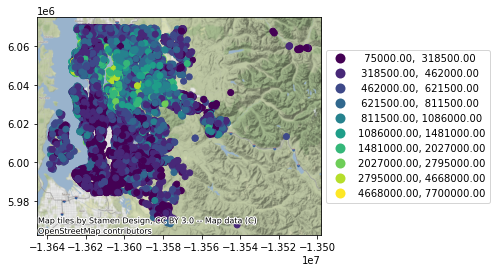

In [11]:
crs = {'init': 'epsg:4326'}
geometry = [Point(x,y) for x,y in zip(df.long,df.lat)]
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)
geo_df_wm = geo_df.to_crs(epsg=3857)

ax = geo_df_wm.plot(
    column = 'price',
    scheme="naturalbreaks",
    k = 10,
    legend=True,
    legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)}
)
cx.add_basemap(ax)

<AxesSubplot:xlabel='price', ylabel='Density'>

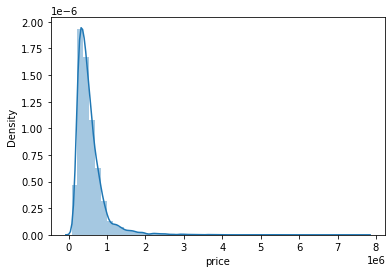

In [4]:
sns.distplot(df['price'])

Kao sto se vidi sa mape i sa grafika vecina kuca ima cenu manju od milion dolara, dok postoji nekoliko outliera sa visemilionskim cenama. Dalje mozemo da vidimo korelacije izmedju atributa.

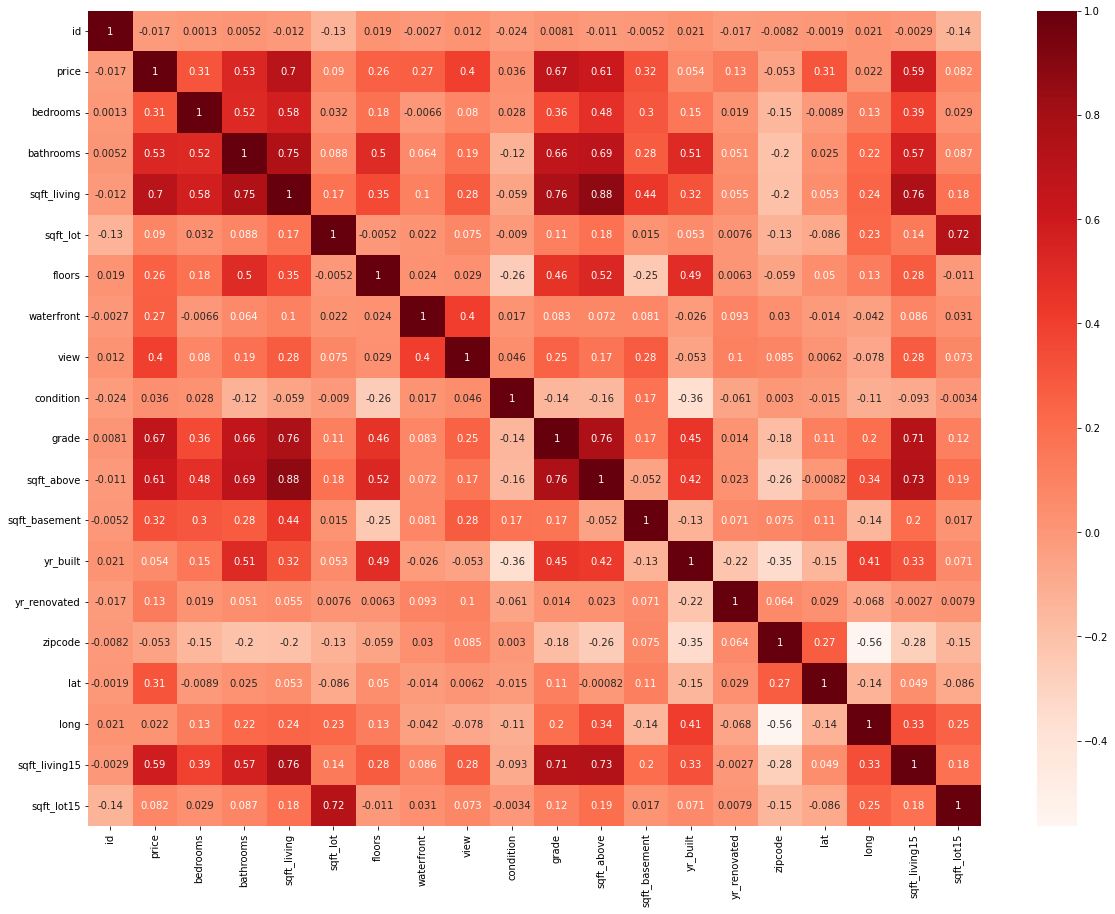

In [5]:
cor = df.corr()
plt.figure(figsize=(20,15))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [6]:
df.corr()["price"].sort_values(ascending=False)

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
id              -0.016762
zipcode         -0.053203
Name: price, dtype: float64

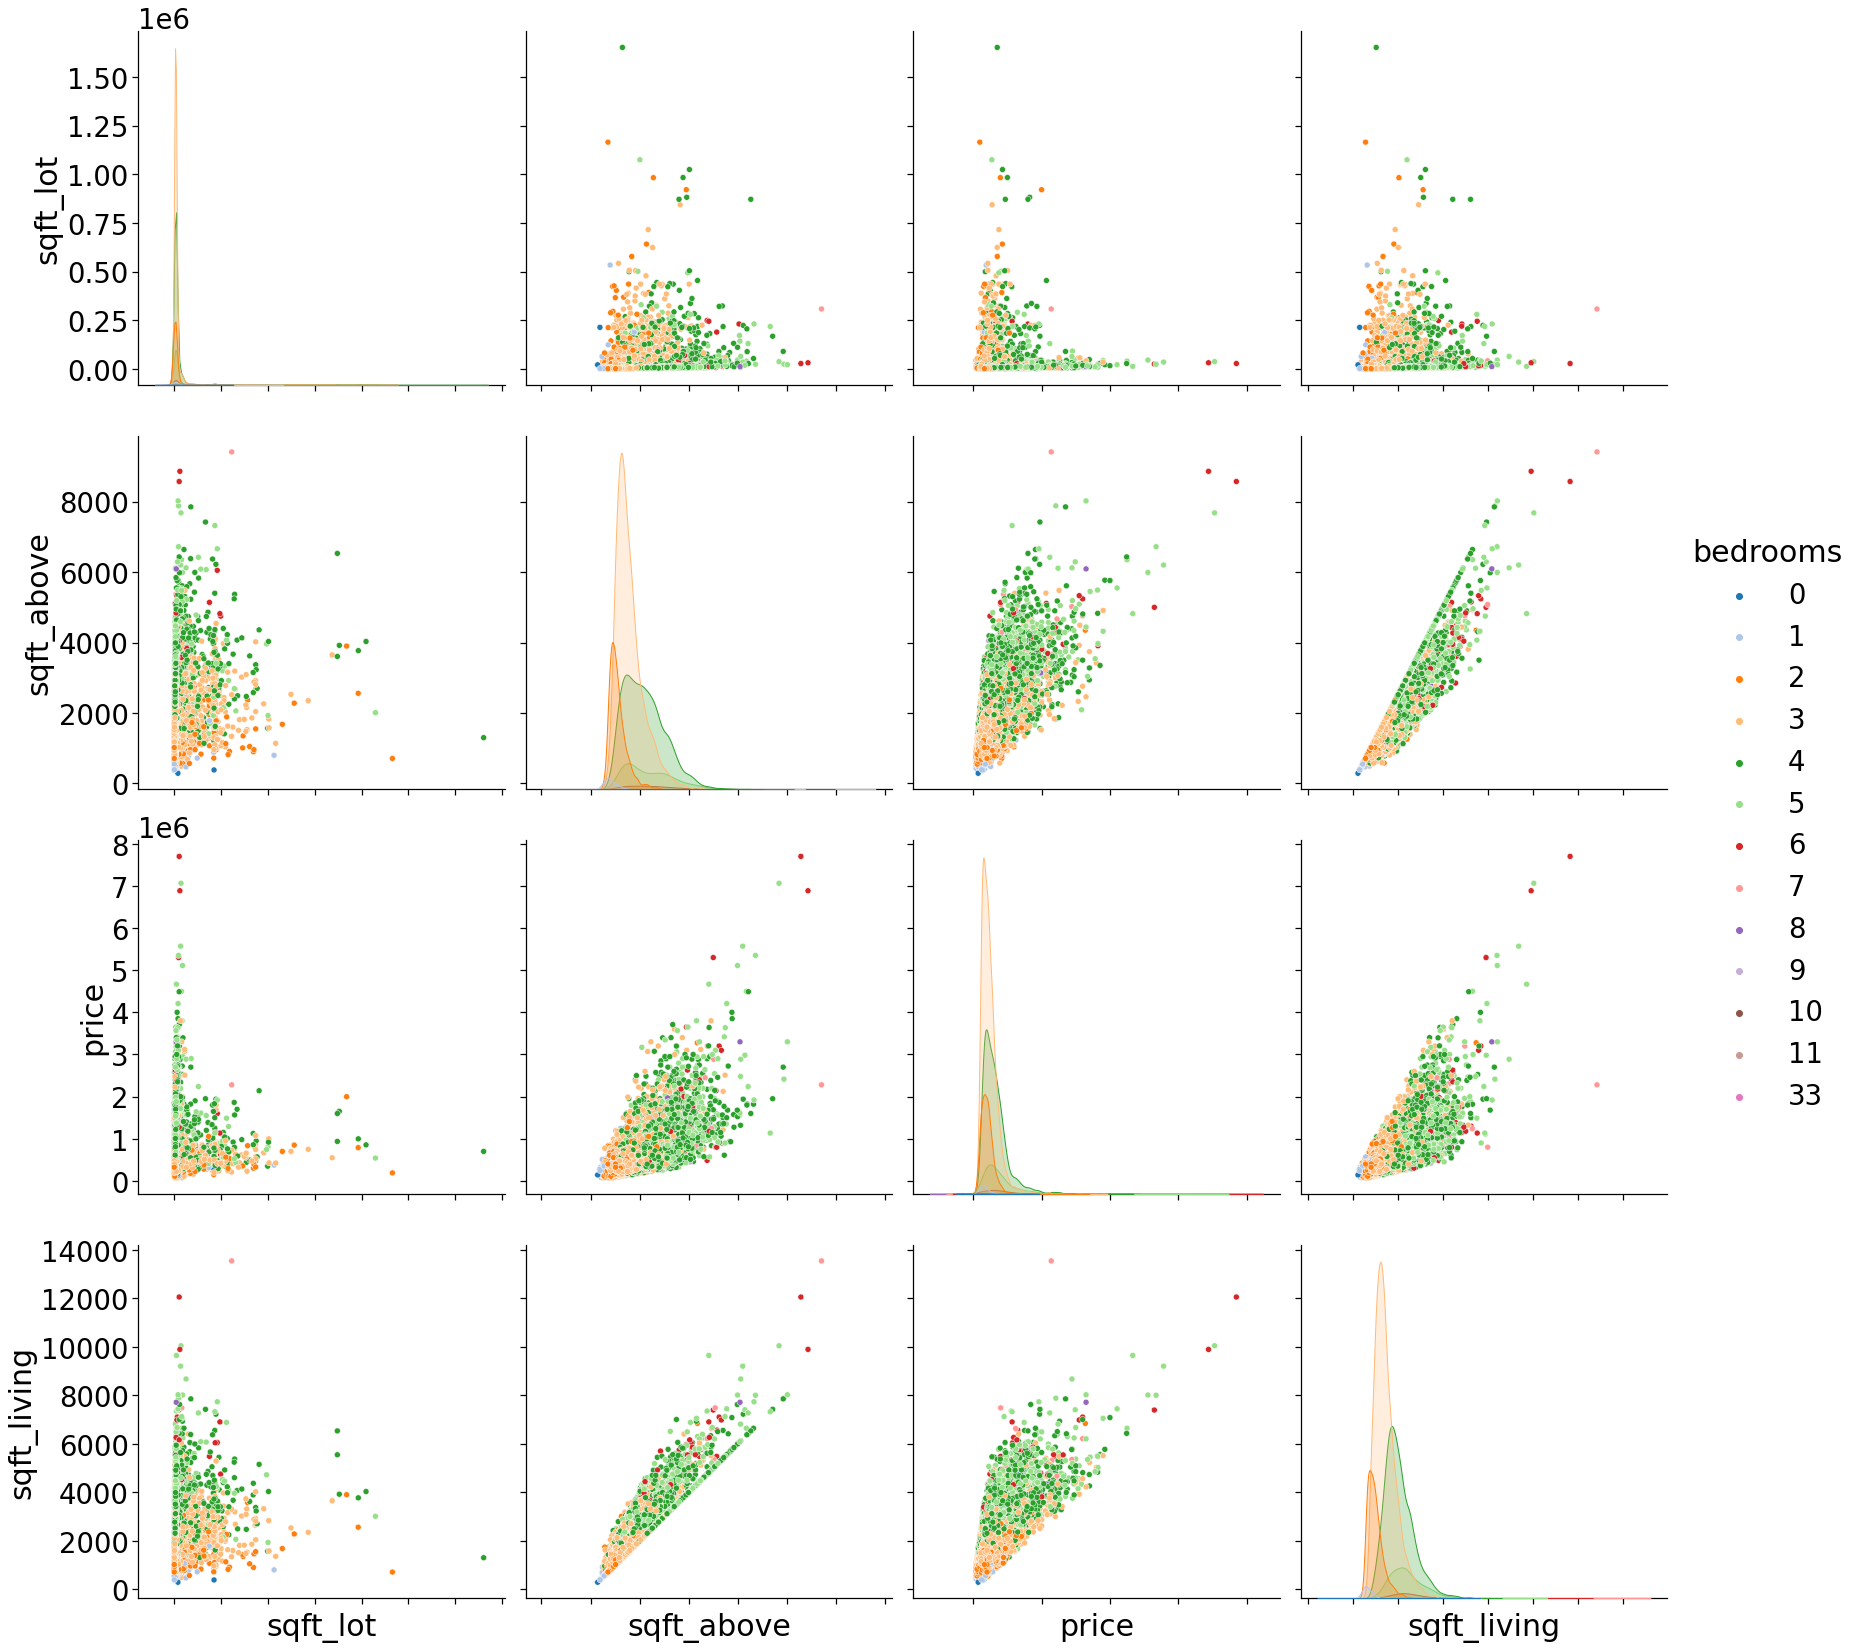

In [7]:
with sns.plotting_context("notebook",font_scale=2.5):
    g = sns.pairplot(df[['sqft_lot','sqft_above','price','sqft_living','bedrooms']], 
                 hue='bedrooms', palette='tab20',height=6)
g.set(xticklabels=[]);